# Approximate the sine function with a polynomial of degree 3

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/pytorch_tuto/pytorch_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be gradually moving up in the abstraction ladder:
- 1. Bare Numpy (You need to compute the gradient by hand)
- 2. Autograd (Here you do not need to compute the gradient by hand anymore)
- 3. torch.nn (Using the nn Abstraction in pytorch)
- 4. Optimizer Abstraction (Finally, we don't even need to iterate on the parameters to update them)


## Tensors
### Warm-up: numpy
Before introducing PyTorch, we will first implement the network using numpy.

Numpy provides an n-dimensional array object, and many functions for manipulating these arrays. Numpy is a generic framework for scientific computing; it does not know anything about computation graphs, or deep learning, or gradients. However we can easily use numpy to fit a third order polynomial to sine function by manually implementing the forward and backward passes through the network using numpy operations.

If you are not familiar with numpy, you can read this cheat sheet: https://www.datacamp.com/cheat-sheet/numpy-cheat-sheet-data-analysis-in-python

```yaml
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend 15~30 min on this exercise.
```

In [1]:
import matplotlib.pyplot as plt


def plot(predicted_y, true_y, x):
    """Plot the predictions and the actual data points"""
    plt.plot(x, true_y, label="y (actual)")
    plt.plot(x, predicted_y, label="y_pred (predicted)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

99 0.540534846025972
199 0.44081754328279604
299 0.3614970021123456
399 0.2966464316049744
499 0.2436172256613333
599 0.20024744090299537
699 0.16477167074919044
799 0.13574812706374173
899 0.11199916093989333
999 0.09256274073534204
1099 0.07665286472911056
1199 0.06362725979233409
1299 0.052961022216563944
1399 0.044225105171485195
1499 0.03706875962971614
1599 0.031205200518675317
1699 0.02639990427650107
1799 0.022461053551618013
1899 0.019231734096541744
1999 0.016583561715142945
Result: y = -0.08929478539698071 + 0.7289103365441492 x + 0.015388778927922163 x^2 + -0.07514310845545627 x^3


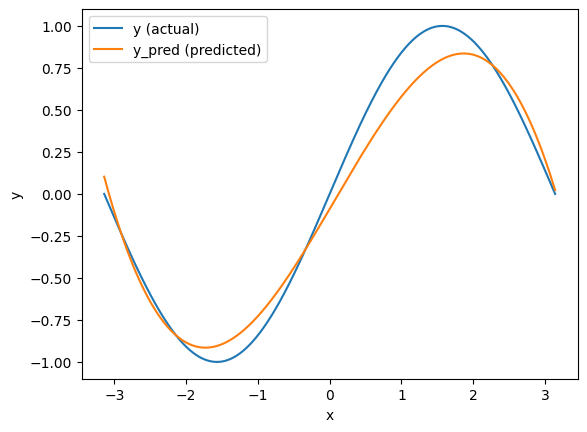

In [4]:
import numpy as np

# Use a 1000 points between -π and π, uniformly spaced for our inputs
x = np.linspace(-np.pi, np.pi, 1000)
# And we'll try to learn true_y = sin(x)
true_y = np.sin(x)

# Randomly initialize 4 weights, the coefficients of or degree 3 polynomial
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-3
epochs = 2000
for t in range(epochs):
    # Forward pass: compute the predicted y
    # y = a + b·x + c·x² + d·x³
    predicted_y = a + b*x + c*x**2 + d*x**3

    # The loss is a measure of how far away the prediction is from the true y
    # Here we use the mean squared error. https://en.wikipedia.org/wiki/Mean_squared_error
    # Computing the loss is not necessary in numpy, but it will be necessary in Pytorch
    loss = np.mean((predicted_y - true_y) ** 2)
    if t % 100 == 99:
        print(t, loss)

    # Compute the gradients of the loss with respect to a, b, c and d
    # Take a pen and paper!
    # Here we calculate the difference for each point and then calculate a gradient for each point.
    # Warning: predicted_y is a vector, and grad_a should be the mean gradient of each component of predicted_y.
    grad_loss = 2 * (predicted_y - true_y) / len(x)
    grad_a = np.sum(grad_loss)
    grad_b = np.dot(grad_loss, x)
    grad_c = np.dot(grad_loss, x**2)
    grad_d = np.dot(grad_loss, x**3)

    # Update weights
    a -= grad_a * learning_rate
    b -= grad_b * learning_rate
    c -= grad_c * learning_rate
    d -= grad_d * learning_rate

print(f"Result: y = {a} + {b} x + {c} x^2 + {d} x^3")
# Tip: If if does not work, try to use .mean() instead of .sum()

# Check with the plot!
plot(predicted_y, true_y, x)

Interpret the results. If the results are correct (the two curves are close), move on to the next exercise.

<details>
<summary>Solution</summary>

```python
predicted_y = a + b * x + c * x ** 2 + d * x ** 3
loss = (predicted_y - true_y).pow(2).mean()

# It's useful to compute the gradient of the loss with respect to predicted_y, as it appears in every computation
grad_predicted_y = 2.0 * (predicted_y - true_y)
grad_a = grad_predicted_y.mean()
grad_b = (grad_predicted_y * x).mean()
grad_c = (grad_predicted_y * x ** 2).mean()
grad_d = (grad_predicted_y * x ** 3).mean()

# Update weights using gradient descent
a -= learning_rate * grad_a
b -= learning_rate * grad_b
c -= learning_rate * grad_c
d -= learning_rate * grad_d
```
</details>

### PyTorch: Tensors

Numpy is a great framework, but it cannot utilize GPUs to accelerate its numerical computations. For modern deep neural networks, GPUs often provide speedups of 50x or greater, so unfortunately numpy won’t be enough for modern deep learning.

Here we introduce the most fundamental PyTorch concept: the Tensor. A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Behind the scenes, Tensors can also keep track of a computational graph (= by which operations they were computed) and gradients, but they’re also useful as a generic tool for scientific computing.

Also unlike numpy, PyTorch Tensors can utilize GPUs to accelerate their numeric computations. To run a PyTorch Tensor on GPU, you simply need to specify the correct device.

Here we use PyTorch Tensors to fit a third order polynomial to sine function. Like the numpy example above we need to manually implement the forward and backward passes through the network.

You can check the pytorch cheat sheet to get back into the swing of things: https://pytorch.org/tutorials/beginner/ptcheat.html

```yaml
Difficulty: 🟠⚪⚪⚪⚪
Importance: 🔵⚪⚪⚪⚪

Don't spend more than 10 minutes on this exercise.
This is very close to the numpy implementatiion, and is more a translation exercise than one where you need to think a lot. We're just doing things step by step.
```

In [ ]:
import torch


# Create input and target tensors
x = torch.linspace(-torch.pi, torch.pi, 1000)
true_y = torch.sin(x)

# Randomly initialize weights
a = torch.randn(())
b = torch.randn(())
c = torch.randn(())
d = torch.randn(())

learning_rate = 1e-3
epochs = 2000
for t in range(epochs):
    # Forward pass: compute predicted y
    predicted_y = ...

    # Compute and print loss
    loss = ...
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_a = ...
    grad_b = ...
    grad_c = ...
    grad_d = ...

    # Update weights using gradient descent
    a -= ...
    b -= ...
    c -= ...
    d -= ...


print(f"Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3")

# Check with the plot!
plot(predicted_y, true_y, x)

<details>
<summary>Solution</summary>

The solution of the previous exercise actually works for this one too. However, if you used functions such
as `np.mean()` you should just replace them by their pytorch equivalent (here `torch.mean()`).
</details>

## Autograd
### PyTorch: Tensors and autograd
In the above examples, we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very hairy for large complex networks. Imagine explicitly deriving and implementing the gradient of the loss with respect to every weight of a large language model!

Thankfully, we can use automatic differentiation to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph; nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

This sounds complicated, and it is behind the scenes, but it’s pretty simple to use in practice. Each Tensor represents a node in a computational graph. If `x` is a Tensor that has `x.requires_grad = True` then `x.grad` is another Tensor holding the gradient of `x` with respect to some scalar value.

Here we use PyTorch Tensors and autograd to implement our fitting sine wave with third order polynomial example; now we no longer need to manually implement the backward pass through the network:

```yaml
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend 15~20 min on this exercise.
```

In [ ]:
# Here You must use AUTOGRAD, ie, no need to calculate by hand the gradient.
import torch

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-torch.pi, torch.pi, 1000)
true_y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), requires_grad=True)
b = torch.randn((), requires_grad=True)
c = torch.randn((), requires_grad=True)
d = torch.randn((), requires_grad=True)

learning_rate = 1e-3
epochs = 2000
for t in range(epochs):
    # Forward pass: compute predicted y using operations on Tensors. (same as above)
    predicted_y = ...

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = ...
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    # Hint: using autograd is as simple as calling .backward() on the correct variable.
    ...

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= ...
        b -= ...
        c -= ...
        d -= ...

        # Manually zero the gradients after updating weights
        # You can assign None or torch.zeros_like(a)
        a.grad = ...
        b.grad = ...
        c.grad = ...
        d.grad = ...

print(f"Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3")

# Check with the plot!
plot(predicted_y.detach(), true_y, x)

<details>
<summary>Solution</summary>

```python
predicted_y = a + b * x + c * x ** 2 + d * x ** 3
loss = (predicted_y - true_y).pow(2).mean()

# Using autograd is as simple as calling backward() on the correct variable
loss.backward()

# Update weights using gradient descent
a -= learning_rate * a.grad
b -= learning_rate * b.grad
c -= learning_rate * c.grad
d -= learning_rate * d.grad

# Manually zero the gradients after updating weights
a.grad = None
b.grad = None
c.grad = None
d.grad = None
```
</details>

## nn module
### PyTorch: nn
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In TensorFlow, packages like Keras, TensorFlow-Slim, and TFLearn provide higher-level abstractions over raw computational graphs that are useful for building neural networks.

In PyTorch, the nn package serves this same purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In this example we use the nn package to implement our polynomial model network.

```yaml
Difficulty: 🟠🟠⚪⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend 20~30 min on this exercise.
```

In [ ]:
# Complete the ??? and the ...
import torch


# Create Tensors to hold input and outputs.
x = torch.linspace(-torch.pi, torch.pi, 1000)
true_y = torch.sin(x)

# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
powers = torch.tensor([1, 2, 3])
powers_of_x = x.unsqueeze(-1).pow(powers)

# First part of the exercise: complete the shapes of the tensors above.
assert x.shape == (1000,)
assert x.unsqueeze(-1).shape == ...
assert powers.shape == ...
# For the last case, broadcasting semantics will apply to obtain a tensor
# Broadasting rules (if needed): https://numpy.org/doc/stable/user/basics.broadcasting.html
# Make sure you understand this one enough to explain it to someone else (do it!).
assert powers_of_x.shape == ...
print("All assertions passed!")


# We use the nn package to define our model as a sequence of layers.
# 1) nn.Sequential is a Module which contains other Modules, and applies them in
# sequence to produce its output.
# 2) The Linear Module computes output from input using a linear function, and
# holds internal Tensors for its weight and bias.
# 3) The Flatten layer flatens the output of the linear layer to a 1D tensor, to
# match the shape of `y`.
model = torch.nn.Sequential(
    # Important note: Linear contains a matrix that is always applied to the last dimension of a tensor.
    torch.nn.Linear(3, 1),
    # TODO: After the linear layer, the shape is ...
    # Note: Flatten default arguments are Flatten(start_dim = 1, end_dim = -1)
    # By default, start_dim = 1 because 0 corresponds to the batch dimension.
    # We use flatten because we want the final tensor to match the shape of y.
    torch.nn.Flatten(start_dim=0, end_dim=1),
    # TODO: After the flatten layer, the shape is ...
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="mean")

learning_rate = 1e-3
epochs = 2000
for t in range(epochs):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    predicted_y = model(powers_of_x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(predicted_y, true_y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= ...

# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(
    f'Result: y = {linear_layer.bias.item()} + "{linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3'
)

# Check with the plot!
plot(predicted_y.detach(), true_y, x)

## PyTorch: optim
Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters with torch.no_grad(). This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp, Adam, etc.

The optim package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

In this example we will use the nn package to define our model as before, but we will optimize the model using the RMSprop algorithm provided by the optim package.

```yaml
Difficulty: 🟠⚪⚪⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend 10~20 min on this exercise.
```

In [ ]:
# Adapt the above code to use torch.optim.SGD
# You can read back the quick start https://pytorch.org/tutorials/beginner/basics/intro.html
...

## Bonus: Using the GPU

Unlike numpy, PyTorch can utilize GPUs to accelerate its numerical computations. To run a PyTorch Tensor on GPU, you simply need to specify the correct device.

Adapt your previous code to run on the GPU. It should be as simple as defining `device = torch.device("cuda")` and passing a `device=device` to functions that create tensors.

Compare with `device = torch.device("cpu")`.
Does it run faster? Why?

In [ ]:
assert (
    torch.cuda.is_available()
), "No GPU found. In Colab, go to Runtime -> Change runtime type -> GPU"

<details>
<summary>Solution</summary>

```python
device = torch.device("cuda")

# Create input and target tensors
x = torch.linspace(-torch.pi, torch.pi, 1000, device=device)
true_y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device)
b = torch.randn((), device=device)
c = torch.randn((), device=device)
d = torch.randn((), device=device)

...
```
</details>